<a href="https://colab.research.google.com/github/daisy-dotcom/pamap2_models/blob/main/islp_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchinfo

In [ ]:
import os
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd


import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.nn import functional as F
from torchinfo import summary

In [ ]:
pamap2_label_names = [
    'lying',
    'sitting',
    'standing',
    'walking',
    'running',
    'cycling',
    'Nordic_walking',
    'ascending stairs',
    'descending stairs',
    'vacuum_cleaning',
    'ironing',
    'rope_jumping'
]

pamap2_label_num = [1,2,3,4,5,6,7,12,13,16,17,24]

pamap2_updated_labels =[
    'lying',
    'sitting',
    'standing',
    'walking',
    'running',
    'stairs',
]

'''
  1 - lying
  2 - sitting
  3 - standing
  4 - walking
  5 - running
  7 - Nordic_walking  -> changed to the same label as walking
  12 - ascending stairs
  13 - descending stairs

  ascending/descending stais -> just stairs now
'''
labels_to_keep = [1,2,3,4,5,7,12,13]

new_labels = [0,1,2,3,4,5]

In [ ]:
torch.get_default_device()

device(type='cpu')

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.set_default_device(torch.device(device))

torch.cuda.is_available()

True

In [ ]:
torch.get_default_device()

device(type='cuda', index=0)

In [ ]:
class AccDataReader:
  def __init__(self,
               data_path,
               overlap=False,
               data_cols=[4,5,6],
               label_col=[1],
               samp_rate=100,
               window_size=1):

    self.data_path = data_path
    self.data_cols = data_cols
    self.label_col = label_col
    self.window_size = int(window_size * samp_rate)
    self.overlap = overlap

    self.file_list = self._get_file_list(self.data_path)
    self._read_data()

  def _get_file_list(self, data_path):
    self.cwd = os.getcwd()
    try:
      file_list = [ single_file for single_file in os.listdir(os.path.join(self.cwd, self.data_path)) \
                if os.path.isfile(os.path.join(self.cwd, self.data_path, single_file))]
      #return ['subject104.dat','subject108.dat','subject107.dat']
      #, 'subject109.dat'
      return file_list
    except OSError as e:
      print(f'Error: {e}')
      return []

  def _read_data(self):

    data = []
    labels = []
    no_data = []


    for single_file in self.file_list:
      with open(os.path.join(self.cwd, self.data_path, single_file), 'r') as f:
        individual_data = []
        individual_labels = []
        print(f"Reading {single_file}")
        for line in f.readlines():
          reading = line.split()

          # exclude readings with a label = 0 and x,y,z = not a number (nan)
          label = reading[self.label_col[0]]
          x, y, z = reading[self.data_cols[0]], reading[self.data_cols[1]], reading[self.data_cols[2]]

          if (label != '0') and ('NaN' not in (x,y,z)) and (int(label) in labels_to_keep):
            individual_data.append([x,y,z])
            if label == '7':
              label = '4'
            elif label == '12':
              label = '6'
            elif label == '13':
              label = '6'


            individual_labels.append(f'{int(label)-1}')

        if len(individual_data) > 0 and len(individual_data) > 0 :
          data.append(individual_data)
          labels.append(individual_labels)
        else:
          no_data.append(single_file)

    for data_file in no_data:
      print(f'No data in {data_file}')
      self.file_list.remove(data_file)


    # length of data and label lists = number of subjects
    self.data = data
    self.labels = labels

  def loso_groups(self):
    loo = LeaveOneOut()

    x_train_idx = []
    y_train_idx = []

    x_test_idx = []
    y_test_idx = []

    for i, (train_index, test_index) in enumerate(loo.split(self.data)):
      #print(f"Fold {i}:")
      #print(f"Train: index={train_index}")
      #print(f"Test:  index={test_index}")

      x_train_idx.append(train_index)
      x_test_idx.append(test_index)

    self.x_train_idx = x_train_idx
    self.x_test_idx = x_test_idx

    #return x_train_idx, x_test_idx

  def get_train_test_data(self, x_train_idx, x_test_idx):
    x_train = []
    y_train = []

    x_test = []
    y_test = []

    for idx in x_train_idx:
      x_train += self.data[idx]
      y_train += self.labels[idx]

    for idx in x_test_idx:
      x_test += self.data[idx]
      y_test += self.labels[idx]

    x_train = np.array(x_train, dtype=np.float64)
    y_train = np.array(y_train, dtype=np.int32)

    x_test = np.array(x_test, dtype=np.float64)
    y_test = np.array(y_test, dtype=np.int32)

    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test


  #def get_features(self, f_set='yuan'):
  #  if f_set == 'yuan':
  #    self.x_train = np.array([yuan_feature_eng(self.x_train[i:i+self.window_size]) for i in range(0,len(self.x_train),self.window_size) if len(self.x_train[i:i+self.window_size]) == self.window_size])
  #    self.x_test = np.array([yuan_feature_eng(self.x_test[i:i+self.window_size]) for i in range(0,len(self.x_test),self.window_size) if len(self.x_test[i:i+self.window_size]) == self.window_size])
  #  else:
  #    self.x_train = np.array([yaz_feature_eng(self.x_train[i:i+self.window_size]) for i in range(0,len(self.x_train),self.window_size) if len(self.x_train[i:i+self.window_size]) == self.window_size])
  #    self.x_test = np.array([yaz_feature_eng(self.x_test[i:i+self.window_size]) for i in range(0,len(self.x_test),self.window_size) if len(self.x_test[i:i+self.window_size]) == self.window_size])

  def get_mode_labels(self):
    self.y_train = np.array(mode_labels(self.y_train, self.window_size, self.overlap))
    self.y_test = np.array(mode_labels(self.y_test, self.window_size, self.overlap))

  def segment_data(self):
    # 50% overlap
    if self.overlap:
      self.x_train = np.array([self.x_train[i:i+self.window_size] for i in range(0,len(self.x_train),self.window_size//2) if len(self.x_train[i:i+self.window_size]) == self.window_size])
      self.x_test = np.array([self.x_test[i:i+self.window_size] for i in range(0,len(self.x_test),self.window_size//2) if len(self.x_test[i:i+self.window_size]) == self.window_size])
    else:
      self.x_train = np.array([self.x_train[i:i+self.window_size] for i in range(0,len(self.x_train),self.window_size) if len(self.x_train[i:i+self.window_size]) == self.window_size])
      self.x_test = np.array([self.x_test[i:i+self.window_size] for i in range(0,len(self.x_test),self.window_size) if len(self.x_test[i:i+self.window_size]) == self.window_size])



In [ ]:
def mode_labels(labels, window_size=100, overlap=False):
  # only keep the label and not the count
  if overlap:
    return [stats.mode(labels[i:i+window_size])[0] for i in range(0,len(labels),window_size//2) if len(labels[i:i+window_size]) == window_size]
  else:
    return [stats.mode(labels[i:i+window_size])[0] for i in range(0,len(labels),window_size) if len(labels[i:i+window_size]) == window_size]

In [ ]:
def performance_eval(y_true, y_pred):
  accuracy = metrics.accuracy_score(y_true, y_pred)
  precision = metrics.precision_score(y_true, y_pred, average='macro', zero_division=0.0)
  recall = metrics.recall_score(y_true, y_pred, average='macro', zero_division=0.0)
  f1_score = metrics.f1_score(y_true, y_pred, average='macro', zero_division=0.0)
  conf_matrix = confusion_matrix(y_true, y_pred, labels=new_labels, normalize='true')

  combined_labels = np.concatenate((y_true, y_pred))
  unique_labels = np.unique(combined_labels)
  if unique_labels.size > 1:
    cohen_kappa = metrics.cohen_kappa_score(y_true, y_pred)
  else:
    cohen_kappa = 1

  return accuracy, precision, recall, cohen_kappa, f1_score, conf_matrix

In [ ]:
def weights_init(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv1d:
        nn.init.xavier_uniform_(module.weight)

In [ ]:
class Residual(nn.Module):
  def __init__(self,
               channels,
               batchnorm=True,
               use_1x1conv=False,
               strides=1):
    super().__init__()
    self.conv1 = nn.LazyConv1d(channels, kernel_size=1, padding='same')
    self.max_pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)

    self.conv2 = nn.LazyConv1d(channels, kernel_size=1, padding='same')
    self.conv3 = nn.LazyConv1d(channels, kernel_size=3, padding='same')
    self.conv4 = nn.LazyConv1d(channels, kernel_size=5, padding='same')

    self.conv5 = nn.LazyConv1d(channels, kernel_size=1, padding='same')

    self.batchnorm = batchnorm


    if torch.cuda.is_available():
      self.device = torch.device('cuda')
    else:
      self.device = torch.device('cpu')

    self.to(self.device)

  def forward(self, x):

    if self.batchnorm:
      net = nn.Sequential(
          nn.LazyBatchNorm1d(),
          nn.ReLU())
      x = net(x)

    #if self.activation:
    #  x = nn.ReLU(x)

    x1 = self.conv1(x)
    x2 = self.max_pool(x)

    x3 = self.conv2(x1)
    x4 = self.conv3(x1)
    x5 = self.conv4(x1)

    x6 = self.conv5(x2)

    return x3 + x4 + x5 + x6


In [ ]:
class ISLPInception(nn.Module):
  def __init__(self,
               num_blocks=3,
               channels=(64, 64, 64),
               num_classes= len(new_labels),
               lr=0.0005):
    super().__init__()
    self.layers = nn.ModuleList()

    self.layers.append(nn.LazyBatchNorm1d())
    self.net = nn.Sequential()

    self.block(num_blocks, channels)

    self.layers.append(nn.Sequential(
                        nn.LazyBatchNorm1d(),
                        nn.ReLU()))

    self.fc = nn.LazyLinear(num_classes)

    self.residual_conn_net = nn.Sequential(
    nn.LazyConv1d(1, kernel_size=1, padding='same'),
    nn.LazyBatchNorm1d()
    )

    self.x_net = nn.Sequential(
        nn.LazyBatchNorm1d(),
        nn.ReLU()
    )

    self.lr = lr

    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]
    self.optim = torch.optim.Adam([{'params': others},
     {'params': bias_params, 'weight_decay': 0}],
                                  lr=self.lr,
                                  weight_decay=0.00593)
    self.loss_function = torch.nn.CrossEntropyLoss()
    self.scheduler = StepLR(self.optim, step_size=10, gamma=0.5)


    if torch.cuda.is_available():
      self.device = torch.device('cuda')
    else:
      self.device = torch.device('cpu')

    self.to(self.device)


  def block(self, num_blocks, channels):
    for i in range(num_blocks):
      if (i == 0) or (i % 3 == 0):
        self.layers.append(Residual(channels[i],
                                    batchnorm=False))
      else:
        self.layers.append(Residual(channels[i]))

  def add(self, x):
    return self.residual_conn_net(self.x_to_add) + self.x_net(x)

  def forward(self, x):
    #self.x_to_add = x
    i = 0
    for idx, layer in enumerate(self.layers):
      x = layer(x)

      if idx == 0:
        self.x_to_add = x

      if type(layer) == Residual:
        i += 1
        if i%3 == 0:
          x = self.add(x)
          self.x_to_add = x

    # global avg pooling
    x = x.mean(2)
    return self.fc(x)

  def loss(self, pred, y_true):
    return self.loss_function(pred, y_true)

In [ ]:
summary(ISLPInception(num_blocks=3, channels=(64, 64, 64)), input_size=(10, 36, 256), dtypes=[torch.float])

Layer (type:depth-idx)                   Output Shape              Param #
ISLPInception                            [10, 6]                   --
├─ModuleList: 1-4                        --                        (recursive)
│    └─BatchNorm1d: 2-1                  [10, 36, 256]             72
│    └─Residual: 2-2                     [10, 64, 256]             --
│    │    └─Conv1d: 3-1                  [10, 64, 256]             2,368
│    │    └─MaxPool1d: 3-2               [10, 36, 256]             --
│    │    └─Conv1d: 3-3                  [10, 64, 256]             4,160
│    │    └─Conv1d: 3-4                  [10, 64, 256]             12,352
│    │    └─Conv1d: 3-5                  [10, 64, 256]             20,544
│    │    └─Conv1d: 3-6                  [10, 64, 256]             2,368
│    └─Residual: 2-3                     [10, 64, 256]             --
│    │    └─Conv1d: 3-7                  [10, 64, 256]             4,160
│    │    └─MaxPool1d: 3-8               [10, 64, 256]  

In [ ]:
class Trainer:
  def __init__(self,
               model_name,
               data,
               batch_size=100,
               n_epoch=50):
    self.model_name = model_name
    self.data = data
    self.batch_size = batch_size
    self.n_epoch = n_epoch

    self.losses_train = np.zeros((n_epoch))
    self.losses_test = np.zeros((n_epoch))
    self.train_acc = np.zeros((n_epoch))
    self.test_acc = np.zeros((n_epoch))

    self.precision = np.zeros((n_epoch))
    self.recall = np.zeros((n_epoch))
    self.cohen_kappa = np.zeros((n_epoch))
    self.f1_score = np.zeros((n_epoch))
    self.conf_matrix = [0 for _ in range(n_epoch)]

    self.results = []

  def _set_model(self):
    model = None
    if self.model_name == 'resnet':
      model = ISLPInception()
    '''if self.model_name == 'chest':
      # needs an update
      model = CNNChest()
    elif self.model_name == 'andrey':
      # needs an update
      model = CNNAndrey()
    else:
      model = CNN()
    '''

    self.model = model
    self.model.apply(weights_init)

  def _get_train_test_data_loader(self):
    self.data.segment_data()
    x_train = self.data.x_train
    x_test = self.data.x_test

    self.data.get_mode_labels()
    y_train = self.data.y_train
    y_test = self.data.y_test

    # create data points and store in data loader class
    x_train = torch.tensor(x_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    x_test= torch.tensor(x_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[-1], x_train.shape[1])
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[-1], x_test.shape[1])

    # load the data into a class that creates the batches
    data_loader = DataLoader(TensorDataset(x_train,y_train),
                             batch_size=self.batch_size,
                             shuffle=True,
                             worker_init_fn=np.random.seed(1),
                             generator=torch.Generator(device=torch.get_default_device()))

    val_loader = DataLoader(TensorDataset(x_test,y_test),
                            batch_size=self.batch_size,
                            shuffle=True,
                            worker_init_fn=np.random.seed(1),
                            generator=torch.Generator(device=torch.get_default_device()))

    return data_loader, val_loader

  def fit_epoch(self, epoch, data_loader, val_loader):
    losses = []
    acc = []

    # loop over batches
    self.model.train()
    for idx, batch in enumerate(data_loader):
        # retrieve inputs and labels for this batch
        x_batch, y_batch = batch
        # zero the parameter gradients
        self.model.optim.zero_grad()
        # forward pass -- calculate model output
        pred = self.model(x_batch)
        # compute the loss
        loss = self.model.loss(pred, y_batch)
        # backward pass
        loss.backward()
        # ADAM update
        self.model.optim.step()

        losses.append(loss.item())

        pred_train_class = torch.argmax(pred, axis=1)
        #print(f'pred_train_class {pred_train_class}')
        #print(f'y_batch {y_batch}')
        batch_acc = (pred_train_class == y_batch).float().sum() / len(y_batch)
        acc.append(batch_acc.item())

    #print('Done training')
    val_loss, val_acc, val_precision, val_recall, val_cohen_kappa, val_f1_score, val_conf_matrix = self.evaluate_model(val_loader)

    self.losses_train[epoch] = np.mean(losses)
    self.losses_test[epoch] = np.mean(val_loss)
    self.train_acc[epoch] = np.mean(acc)
    self.test_acc[epoch] = np.mean(val_acc)

    self.precision[epoch] = np.mean(val_precision)
    self.recall[epoch] = np.mean(val_recall)
    self.cohen_kappa[epoch] = np.mean(val_cohen_kappa)
    self.f1_score[epoch] = np.mean(val_f1_score)
    self.conf_matrix[epoch] = np.mean(np.array(val_conf_matrix), axis=0)


  def train_model(self, data_loader, val_loader):
    for epoch in range(self.n_epoch):
      #print(f'Epoch {epoch}')
      self.fit_epoch(epoch, data_loader, val_loader)

      self.model.scheduler.step()

  def train_and_loso_cv(self):

    self.data.loso_groups()

    # create data points and store in data loader class
    for i in range(len(self.data.x_train_idx)):

      p = self.data.file_list[self.data.x_test_idx[i][0]]

      print(f'Cross Validation on subject: {p}')

      self.data.get_train_test_data(x_train_idx=self.data.x_train_idx[i],
                                  x_test_idx=self.data.x_test_idx[i])

      print(f'Training set: {self.data.x_train_idx[i]}')
      print(f'Testing set: {self.data.x_test_idx[i]}')

      print(f'Training set length: {len(self.data.x_train)}')
      print(f'Testing set length: {len(self.data.x_test)}')
      data_loader, val_loader = self._get_train_test_data_loader()

      self._set_model()

      self.train_model(data_loader, val_loader)

      self.plot(participant=self.data.file_list[self.data.x_test_idx[i][0]])

      self.results.append([np.mean(self.test_acc),
                           np.mean(self.precision),
                           np.mean(self.recall),
                           np.mean(self.cohen_kappa),
                           np.mean(self.f1_score),
                           np.mean(np.array(self.conf_matrix), axis=0)])

  def evaluate_model(self, val_loader):
    # evaluation mode: doesn't update the weights
    # of the model based on the validation data
    self.model.eval()

    batch_losses = []
    batch_acc = []
    batch_precision = []
    batch_recall = []
    batch_cohen_kappa = []
    batch_f1_score = []
    batch_conf_matrix = []

    for i, batch in enumerate(val_loader):
      # disable gradient calculation
      with torch.no_grad():

        # retrieve inputs and labels for this batch
        x_batch, y_batch = batch

        # forward pass -- calculate model output
        pred = self.model(x_batch)

        loss = self.model.loss(pred, y_batch)
        pred_val_class = torch.argmax(pred, axis=1)

        batch_losses.append(loss.item())

        #print(f'pred_val_class {np.unique(pred_val_class.cpu().detach().numpy())}')
        #print(f'y_batch {np.unique(y_batch.cpu().detach().numpy())}')
        accuracy, precision, recall, cohen_kappa, f1_score, conf_matrix = performance_eval(y_batch.cpu().detach().numpy(),
                                                                                           pred_val_class.cpu().detach().numpy())

        batch_acc.append(accuracy)
        batch_precision.append(precision)
        batch_recall.append(recall)
        batch_cohen_kappa.append(cohen_kappa)
        batch_f1_score.append(f1_score)
        batch_conf_matrix.append(conf_matrix)


    return batch_losses, batch_acc, batch_precision, batch_recall, batch_cohen_kappa, batch_f1_score, batch_conf_matrix

  def plot(self, participant):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle(f'{participant}')
    ax[0].plot(self.losses_train,'r-',label='train')
    ax[0].plot(self.losses_test,'b-',label='val')
    ax[0].set_xlim(0,self.n_epoch)
    ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Loss')
    ax[0].set_title('Train loss %3.2f, Val loss %3.2f'%(self.losses_train[-1], self.losses_test[-1]))
    ax[0].legend()

    ax[1].plot(self.train_acc,'r-',label='train')
    ax[1].plot(self.test_acc,'b-',label='val')
    ax[1].set_ylim(0,1);
    ax[1].set_xlim(0,self.n_epoch)
    ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('Acc')
    ax[1].set_title('Train Acc %3.2f, Val Acc %3.2f'%(self.train_acc[-1], self.test_acc[-1]))
    ax[1].legend()
    plt.show()

  def classification_report(self):
    acc = np.mean([res[0] for res in self.results])
    precision = np.mean([res[1] for res in self.results])
    recall = np.mean([res[2] for res in self.results])
    cohen_kappa = np.mean([res[3] for res in self.results])
    f1_score = np.mean([res[4] for res in self.results])
    conf_matrix = np.mean([res[5] for res in self.results], axis=0)

    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Cohen Kappa: {cohen_kappa}')
    print(f'F1 Score: {f1_score}')

    fig, ax = plt.subplots(figsize=(10, 10))

    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=pamap2_updated_labels)
    disp.plot(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_title(f"Confusion Matrix of {self.model_name}")

    plt.savefig(f'pamap2_conf_matrix_{self.model_name}.png')
    plt.show()




In [ ]:
data_path = "drive/MyDrive/dataset/pamap2_data"
overlap = False
acc_data = AccDataReader(data_path, window_size=2.56, overlap=overlap)

Reading subject101.dat
Reading subject102.dat
Reading subject103.dat
Reading subject104.dat
Reading subject105.dat
Reading subject106.dat
Reading subject107.dat
Reading subject109.dat
Reading subject108.dat
No data in subject109.dat


Cross Validation on subject: subject101.dat
Training set: [1 2 3 4 5 6 7]
Testing set: [0]
Training set length: 1138744
Testing set length: 165896


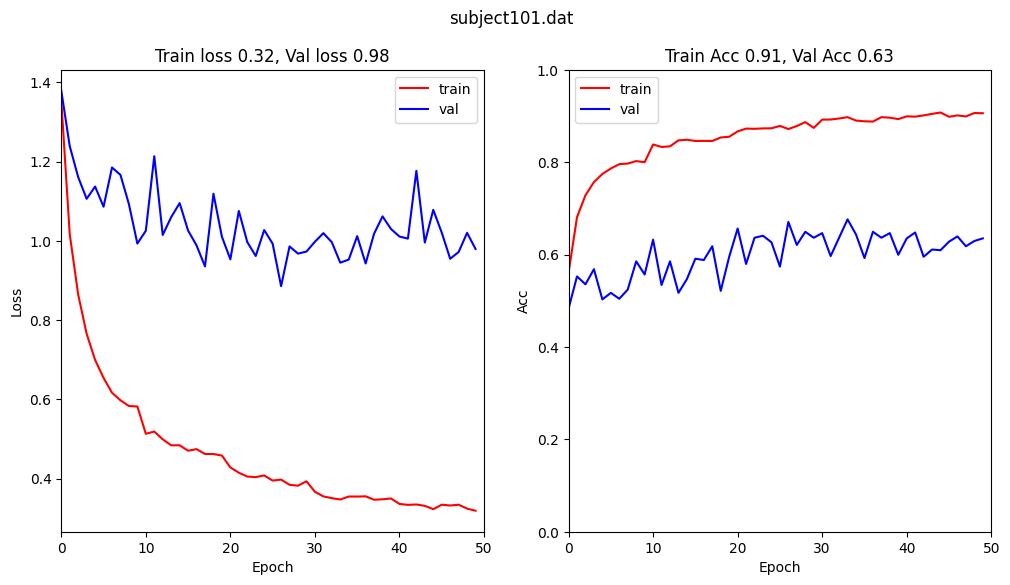

Cross Validation on subject: subject102.dat
Training set: [0 2 3 4 5 6 7]
Testing set: [1]
Training set length: 1131469
Testing set length: 173171


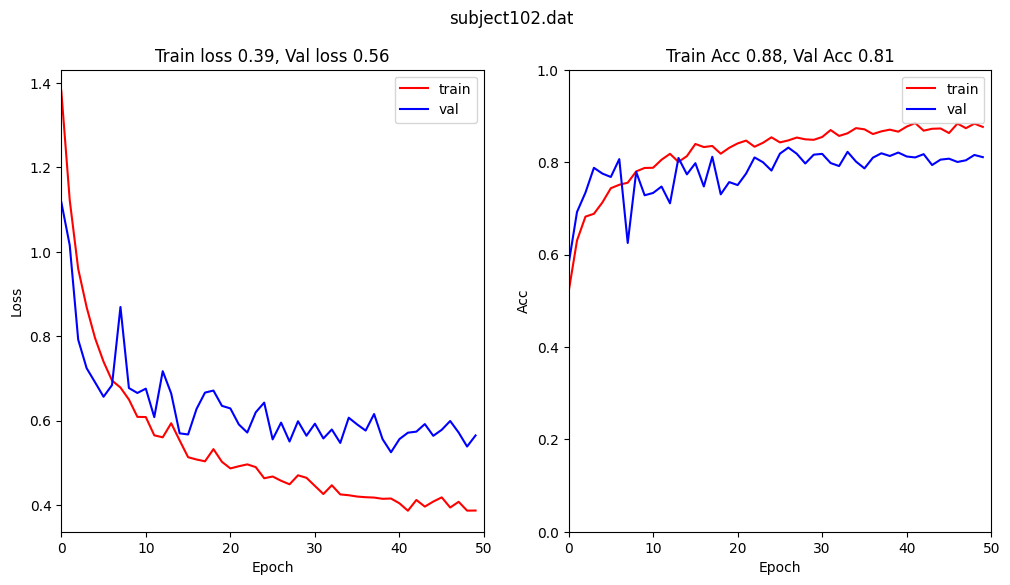

Cross Validation on subject: subject103.dat
Training set: [0 1 3 4 5 6 7]
Testing set: [2]
Training set length: 1179078
Testing set length: 125562


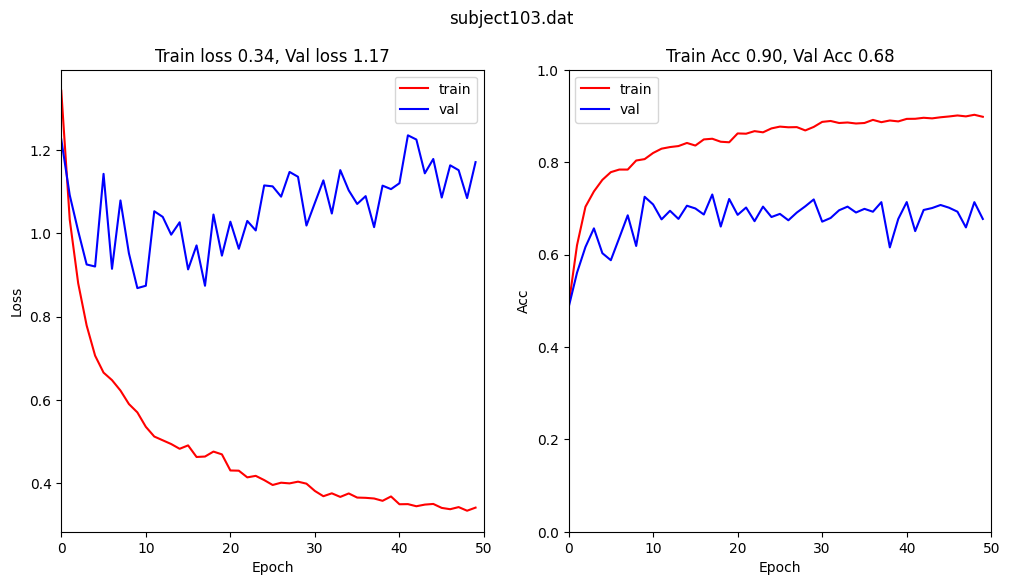

Cross Validation on subject: subject104.dat
Training set: [0 1 2 4 5 6 7]
Testing set: [3]
Training set length: 1143100
Testing set length: 161540


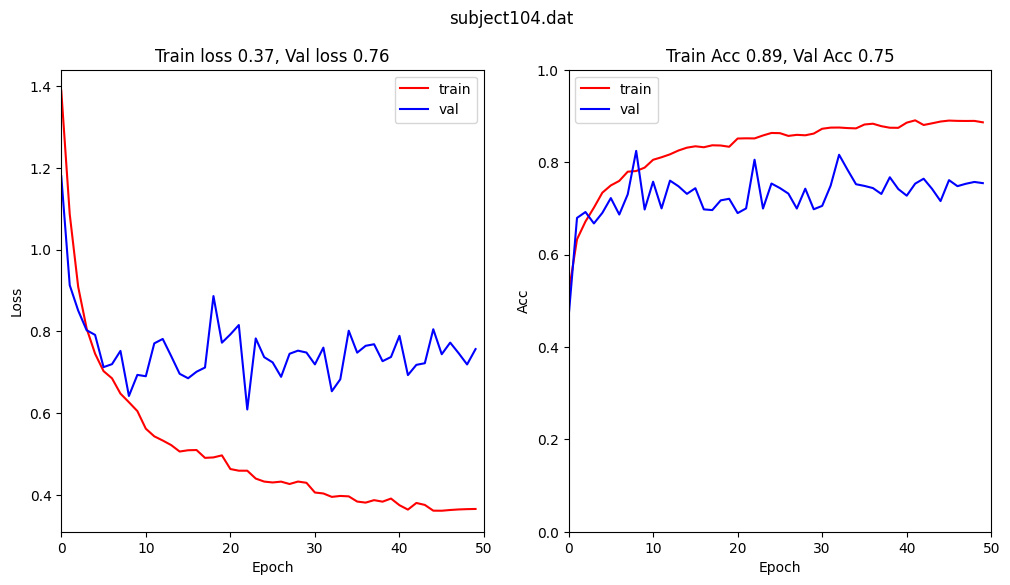

Cross Validation on subject: subject105.dat
Training set: [0 1 2 3 5 6 7]
Testing set: [4]
Training set length: 1123313
Testing set length: 181327


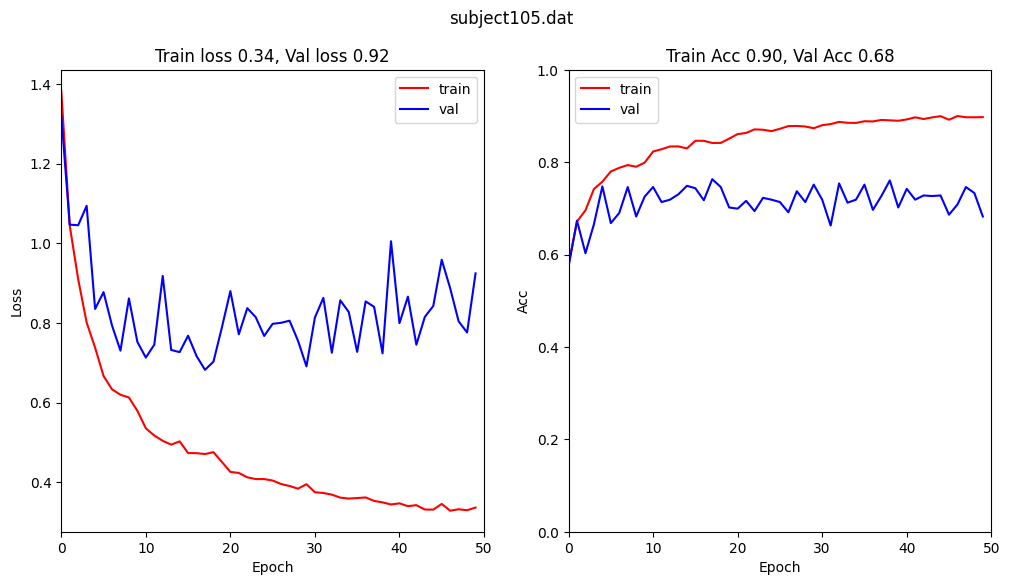

Cross Validation on subject: subject106.dat
Training set: [0 1 2 3 4 6 7]
Testing set: [5]
Training set length: 1134868
Testing set length: 169772


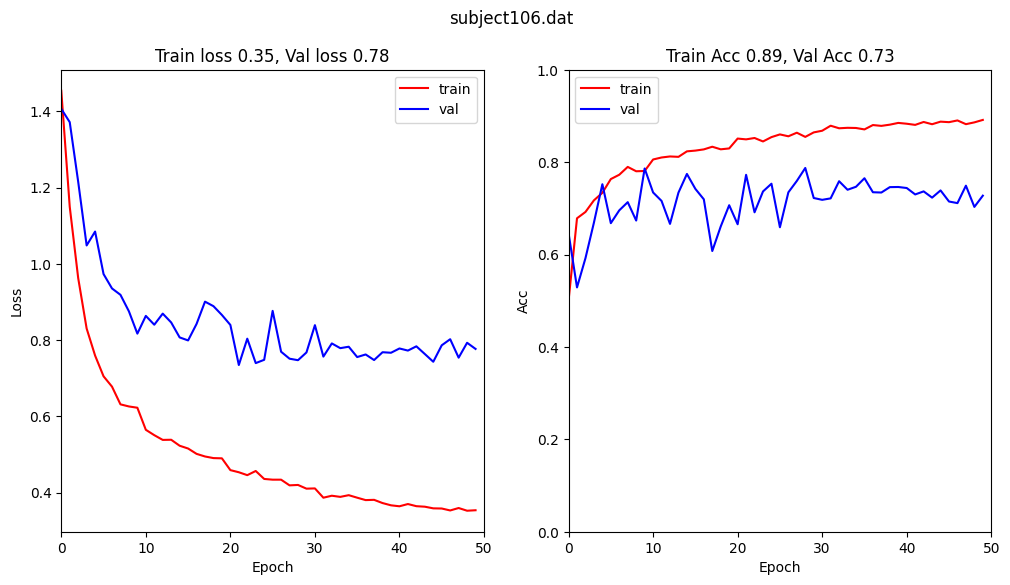

Cross Validation on subject: subject107.dat
Training set: [0 1 2 3 4 5 7]
Testing set: [6]
Training set length: 1146965
Testing set length: 157675


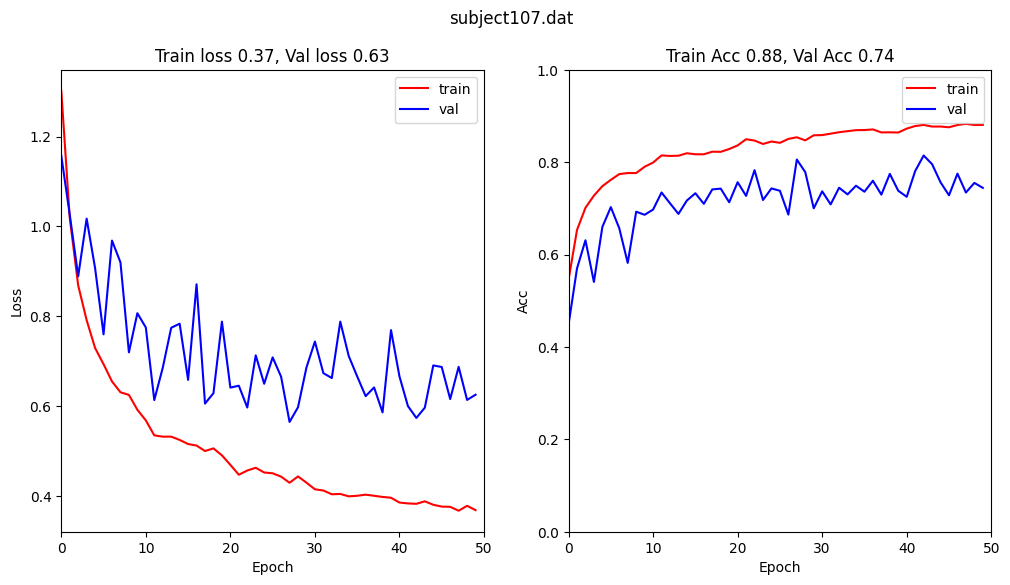

Cross Validation on subject: subject108.dat
Training set: [0 1 2 3 4 5 6]
Testing set: [7]
Training set length: 1134943
Testing set length: 169697


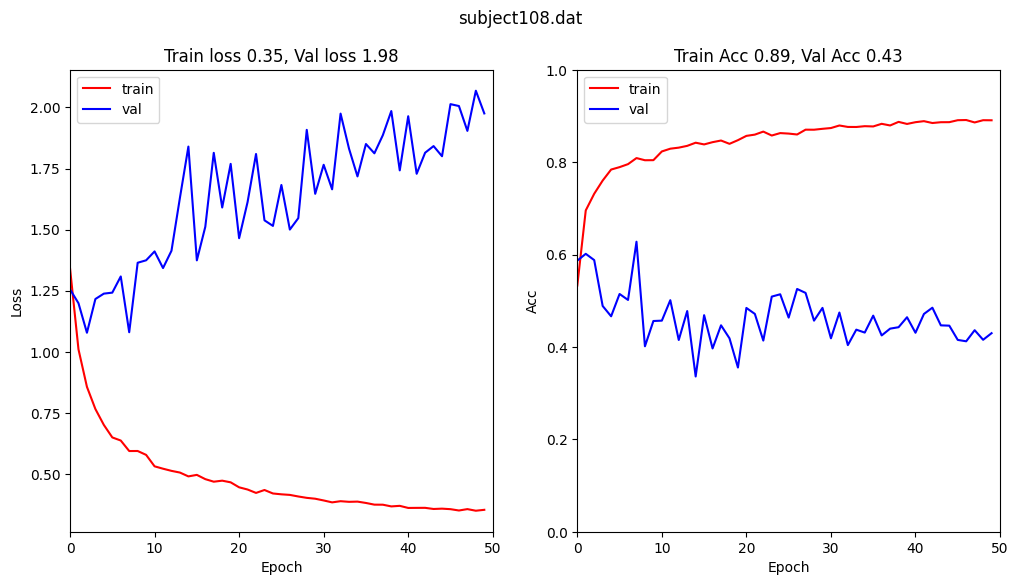

In [ ]:
model_name = 'resnet'
data = acc_data
batch_size = 64
n_epoch = 50

trainer = Trainer(model_name=model_name,
                  data=data,
                  batch_size=batch_size,
                  n_epoch=n_epoch)

trainer.train_and_loso_cv()

Accuracy: 0.6738394516177031
Precision: 0.648245870580291
Recall: 0.6488753587676142
Cohen Kappa: 0.5851191505004084
F1 Score: 0.6199085897824137


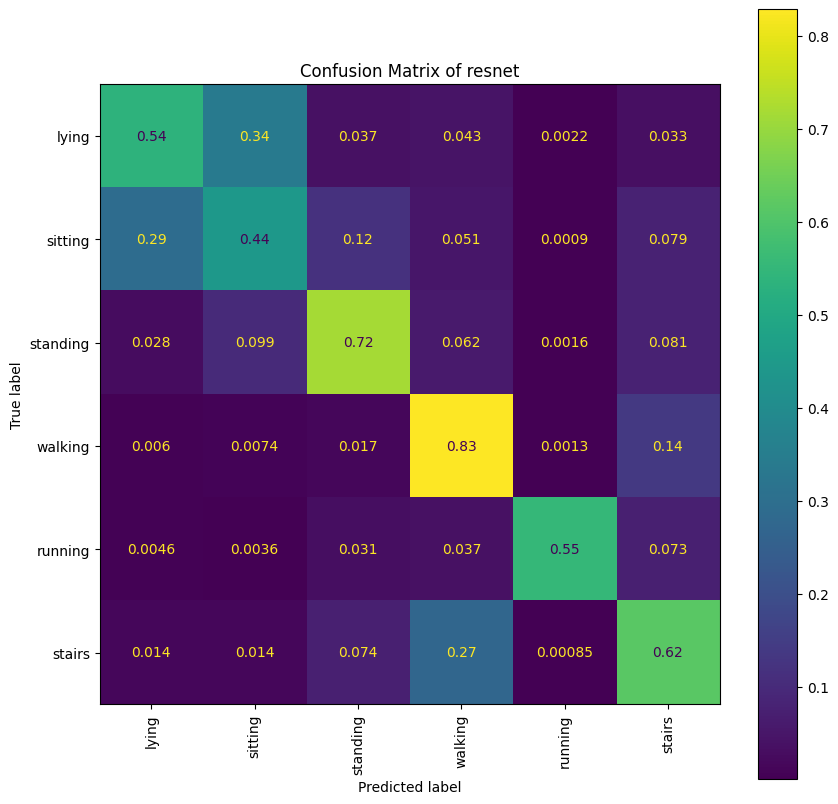

In [ ]:
trainer.classification_report()

In [ ]:
overlap = True
acc_data.overlap = overlap

Cross Validation on subject: subject101.dat
Training set: [1 2 3 4 5 6 7]
Testing set: [0]
Training set length: 1138744
Testing set length: 165896


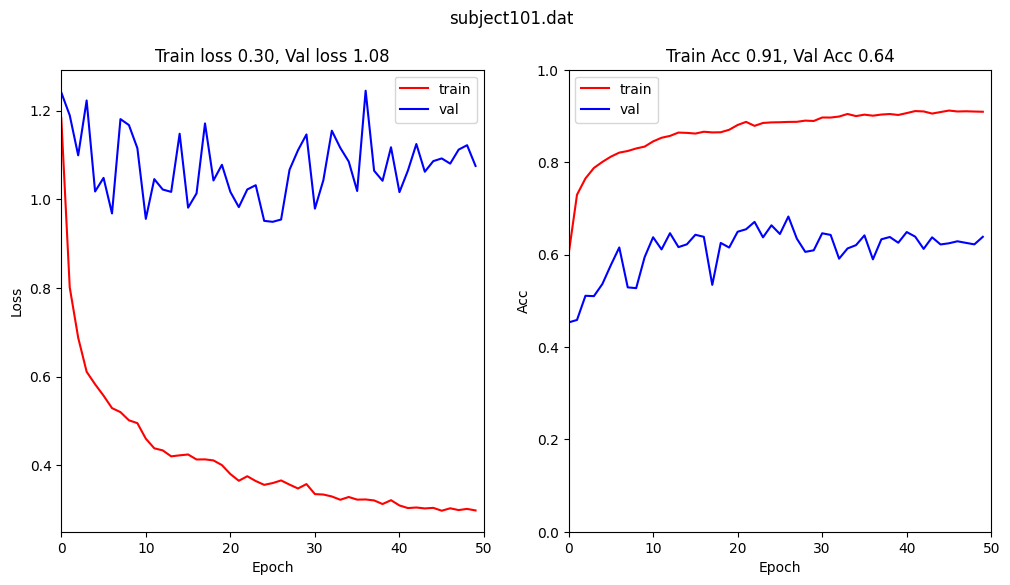

Cross Validation on subject: subject102.dat
Training set: [0 2 3 4 5 6 7]
Testing set: [1]
Training set length: 1131469
Testing set length: 173171


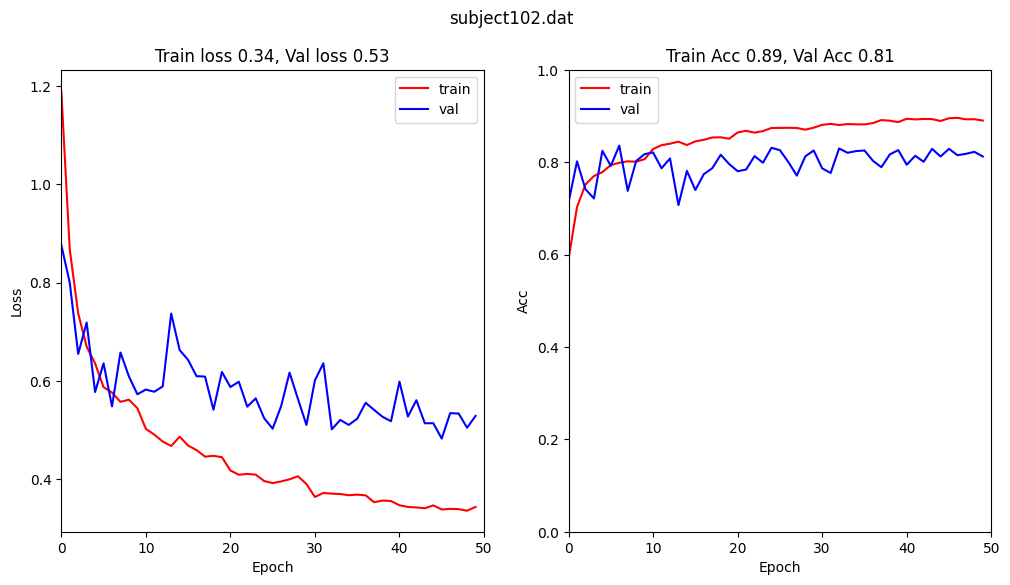

Cross Validation on subject: subject103.dat
Training set: [0 1 3 4 5 6 7]
Testing set: [2]
Training set length: 1179078
Testing set length: 125562


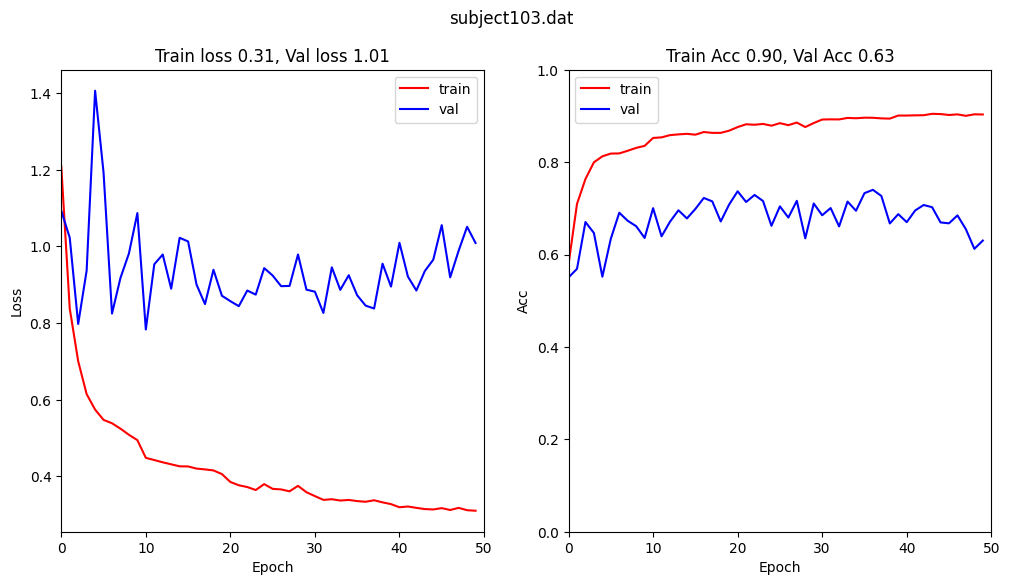

Cross Validation on subject: subject104.dat
Training set: [0 1 2 4 5 6 7]
Testing set: [3]
Training set length: 1143100
Testing set length: 161540


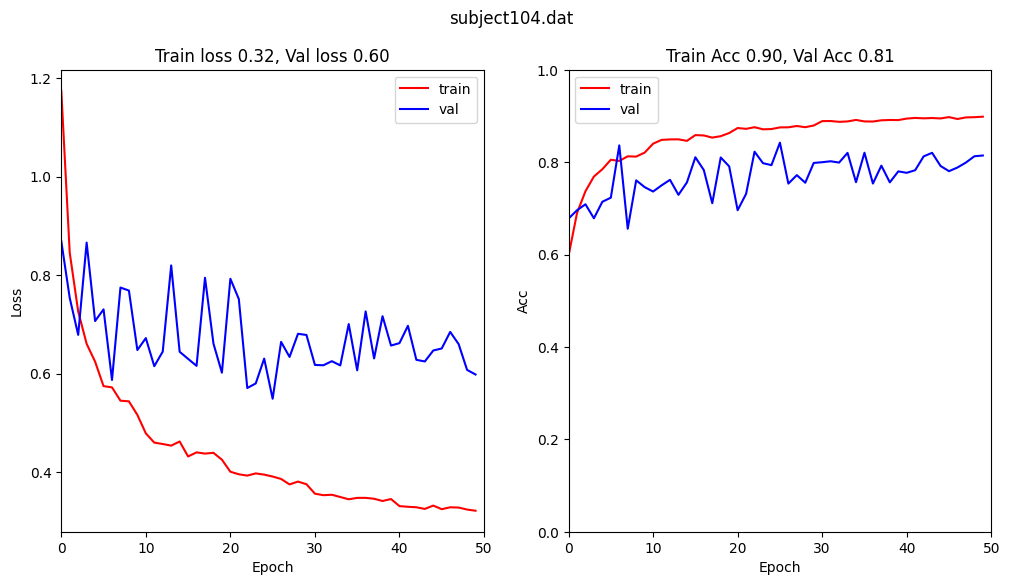

Cross Validation on subject: subject105.dat
Training set: [0 1 2 3 5 6 7]
Testing set: [4]
Training set length: 1123313
Testing set length: 181327


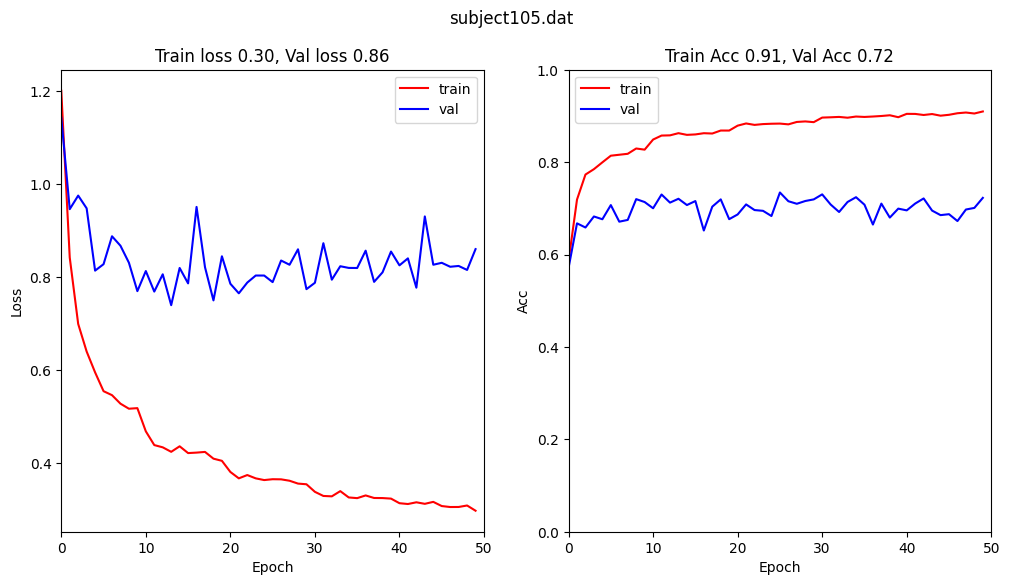

Cross Validation on subject: subject106.dat
Training set: [0 1 2 3 4 6 7]
Testing set: [5]
Training set length: 1134868
Testing set length: 169772


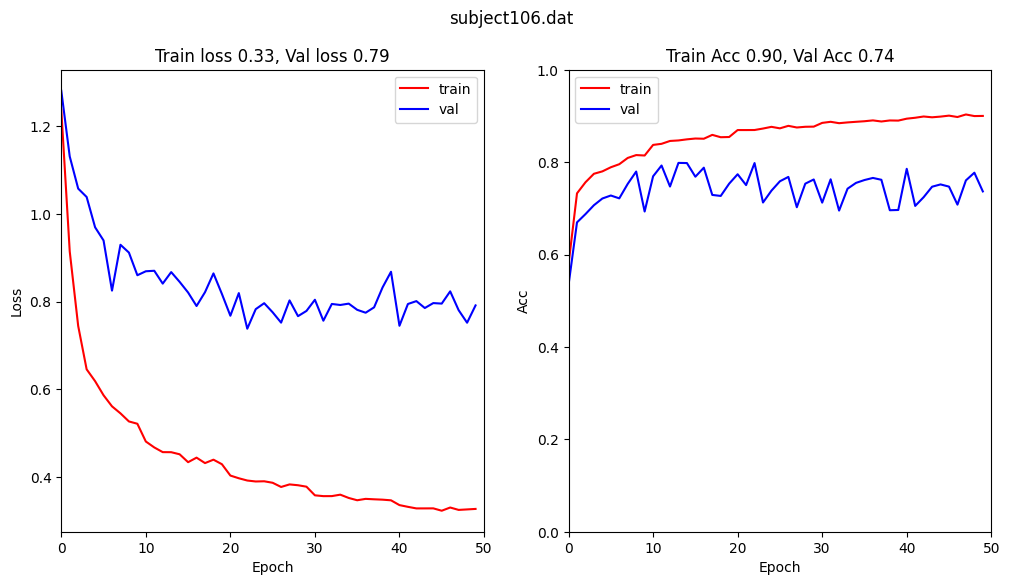

Cross Validation on subject: subject107.dat
Training set: [0 1 2 3 4 5 7]
Testing set: [6]
Training set length: 1146965
Testing set length: 157675


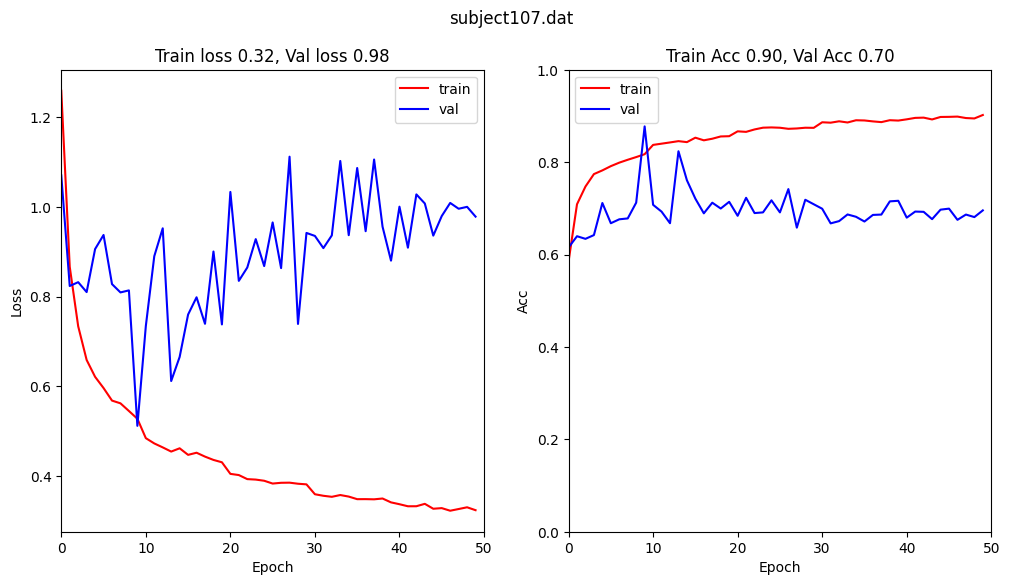

Cross Validation on subject: subject108.dat
Training set: [0 1 2 3 4 5 6]
Testing set: [7]
Training set length: 1134943
Testing set length: 169697


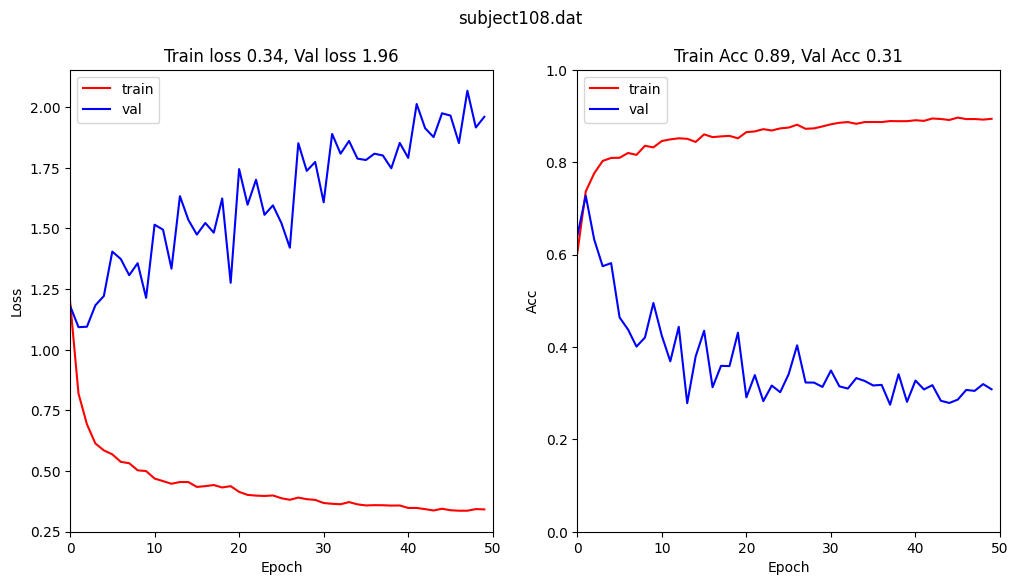

In [ ]:
model_name = 'resnet'
data = acc_data
batch_size = 64
n_epoch = 50

trainer = Trainer(model_name=model_name,
                  data=data,
                  batch_size=batch_size,
                  n_epoch=n_epoch)

trainer.train_and_loso_cv()

Accuracy: 0.6699585863135871
Precision: 0.6474943475333529
Recall: 0.6445546749853353
Cohen Kappa: 0.5806987664459821
F1 Score: 0.6178052400881175


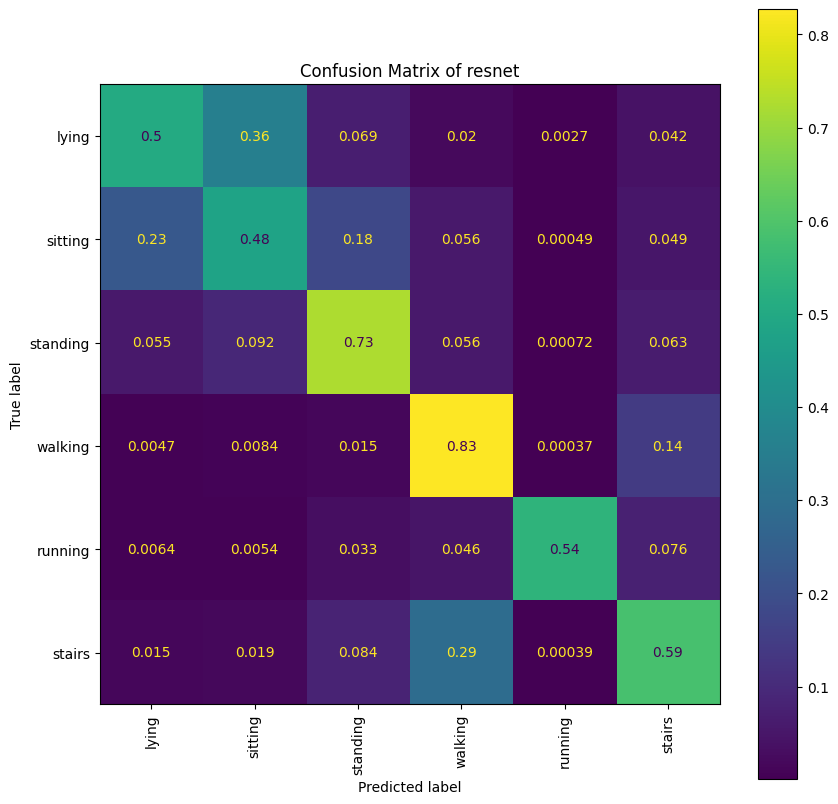

In [ ]:
trainer.classification_report()